### **SIR Model Parameters Estimation**

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm


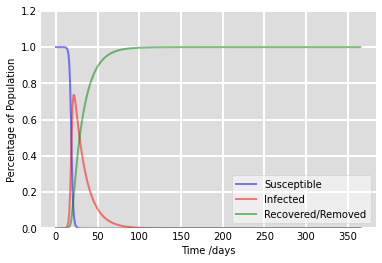

In [77]:
### ------------------- Parameters to Vary ------------------- ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

### ------------------- Fixed Parameters ------------------- ###

# Total population.
N = 300000000

# A grid of time points (in days) for the detecting period
t_set = np.linspace(0, 365, 366)

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 10, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

x = np.linspace(0, 365, 366)

r0_true = np.array([1, 1.2, 1.4, 1.3, 1.2, 1.2, 1, 1, 0.5, 0.5])

def random_beta(t):
        
    if t < 36:
        return r0_true[0]
    if 36 <= t < 72:
        return r0_true[1]
    if 72 <= t < 108:
        return r0_true[2]
    if 108 <= t < 144:
        return r0_true[3]
    if 144 <= t < 180:
        return r0_true[4]
    if 180 <= t < 216:
        return r0_true[5]
    if 216 <= t < 248:
        return r0_true[6]
    if 248 <= t < 284:
        return r0_true[7]
    if 284 <= t < 320:
        return r0_true[8]
    if t > 320:
        return r0_true[9]


### ----------------- Dynamic Parameters ----------------- ###

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
S_syn, I_syn, R_syn = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S_syn/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I_syn/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R_syn/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize as optimize
import torch
import torch.nn.functional as F

In [43]:
class Sigmoid:
    
    def forward(self, Z):
    
        self.A = 1 / (1 + np.exp(-Z)) # TODO
        
        return self.A
    
    def backward(self):
    
        dAdZ = self.A * (1 - self.A) # TODO
        
        return dAdZ

sigmoid = Sigmoid()

In [100]:
# est_R_0 = np.array([0.5] * 10)
weights = np.random.random(size=(24,)) * 2
print(weights)
t_set = np.linspace(0, 365, 366)

def loss_func(weights, I_true):
    
    weights = np.abs(weights)
    # est_R_0 = np.abs(est_R_0)
    # weights = np.abs(weights)
    w1 = weights[:4]
    w2 = weights[4:20].reshape((4, 4))
    w3 = weights[20:]
    
    def random_beta(t):
        
        out = np.dot(w1, t)
        out = sigmoid.forward(out)
        out = np.dot(w2, out)
        out = sigmoid.forward(out)
        out = np.dot(w3, out)
        
        return out
    
    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
    _, I, _ = ret.T
    
    loss = mean_absolute_error(I_true, I)
    
    return loss


[5.63679696e-01 1.24874823e+00 1.83261210e+00 7.63258971e-01
 9.29555998e-01 1.11069988e+00 1.23805949e+00 4.07160561e-01
 3.02511863e-01 7.91145782e-01 9.03156196e-01 1.41725726e+00
 1.43796985e+00 1.87894645e+00 1.66486896e+00 9.81332010e-01
 1.34218506e+00 1.04871179e+00 1.54980708e+00 6.97659038e-01
 3.77721686e-04 1.20030564e+00 1.81960138e-01 2.98832394e-01]


In [101]:
optimizer = optimize.minimize(loss_func, weights, args=(I_syn,), options={'maxiter': 100, 'disp': True})

print(optimizer.x)

         Current function value: 6176.345952
         Iterations: 11
         Function evaluations: 2958
         Gradient evaluations: 118
[ 6.76195700e-01  1.52206313e+00  2.05631195e+00  1.13636159e+00
  8.13910562e-01  1.04545463e+00  1.18967388e+00  3.42941270e-01
 -3.12698158e-05  7.90633609e-01  1.00370783e+00  1.35622378e+00
  1.49985979e+00  1.95589157e+00  1.74841067e+00  1.05299448e+00
  1.36711854e+00  1.07964835e+00  1.58335412e+00  7.26890699e-01
 -1.78513515e-01  5.82783287e-01 -2.32615209e-01 -4.07164881e-02]


In [104]:
weights_pred = np.abs(optimizer.x)
# weights_pred = optimizer.x
w1 = weights_pred[:4]
w2 = weights_pred[4:20].reshape((4, 4))
w3 = weights_pred[20:]
    
def random_beta(t):
    
    out = np.dot(w1, t)
    out = sigmoid.forward(out)
    out = np.dot(w2, out)
    out = sigmoid.forward(out)
    out = np.dot(w3, out)
    
    return out

r0_pred = np.array([random_beta(t) for t in range(366)])

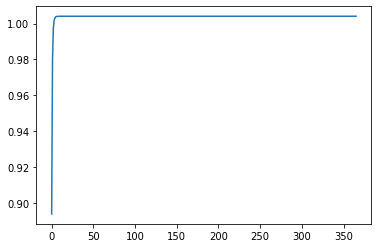

In [105]:
import matplotlib.pyplot as plt

plt.plot(list(range(366)), r0_pred)

In [51]:
weights_pred.sum()

0.0

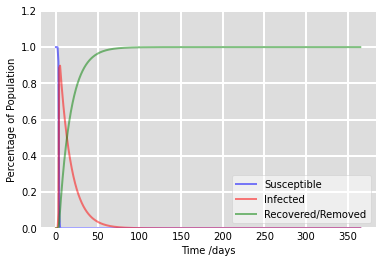

In [51]:
### ------------------- Parameters to Vary ------------------- ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

### ------------------- Fixed Parameters ------------------- ###

# Total population.
N = 300000000

# A grid of time points (in days) for the detecting period
t_set = np.linspace(0, 365, 366)

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 10, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

x = np.linspace(0, 367, 368)

def random_beta(t):
        
    if t < 36:
        return r0_pred[0]
    if 36 <= t < 72:
        return r0_pred[1]
    if 72 <= t < 108:
        return r0_pred[2]
    if 108 <= t < 144:
        return r0_pred[3]
    if 144 <= t < 180:
        return r0_pred[4]
    if 180 <= t < 216:
        return r0_pred[5]
    if 216 <= t < 248:
        return r0_pred[6]
    if 248 <= t < 284:
        return r0_pred[7]
    if 284 <= t < 320:
        return r0_pred[8]
    if t > 320:
        return r0_pred[9]

### ----------------- Dynamic Parameters ----------------- ###

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
S_pred, I_pred, R_pred = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S_pred/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I_pred/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R_pred/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

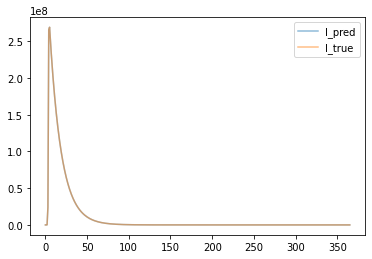

In [52]:
fig, ax = plt.subplots()

ax.plot(list(range(366)), I_pred, label="I_pred", alpha=0.5)
ax.plot(list(range(366)), I_syn, label="I_true", alpha=0.5)
plt.legend()
plt.show()

In [14]:
weights = np.random.randint(5, size=(1088,))
w1 = weights[:32]
w2 = weights[32:1056].reshape((32, 32))
w3 = weights[1056:]

print(w1.shape)
print(w2.shape)
print(w3.shape)

(32,)
(32, 32)
(32,)


In [16]:
input = 150

out = np.dot(w1, input)
out = np.dot(w2, out)
out = np.dot(w3, out)
print(out)

1298400
